# sfHMM

### Contents
1. Basic Usage
2. Parameters and Methods
3. Attributes Added during Analysis
4. Customizing Plots
5. Additional Attributes and Methods in sfHMMn
6. Application to Motor Stepping
7. How to Use Step Finding Classes
8. How to Use GMM Clustering Classes

## 1. Basic Usage
First import `sfHMM1` class and `sfHMMn` class and generate sample data.

In [1]:
from sfHMM import sfHMM1, sfHMMn
from sfHMM import hmm_sampling

For single trajectory, use `sfHMM1`.

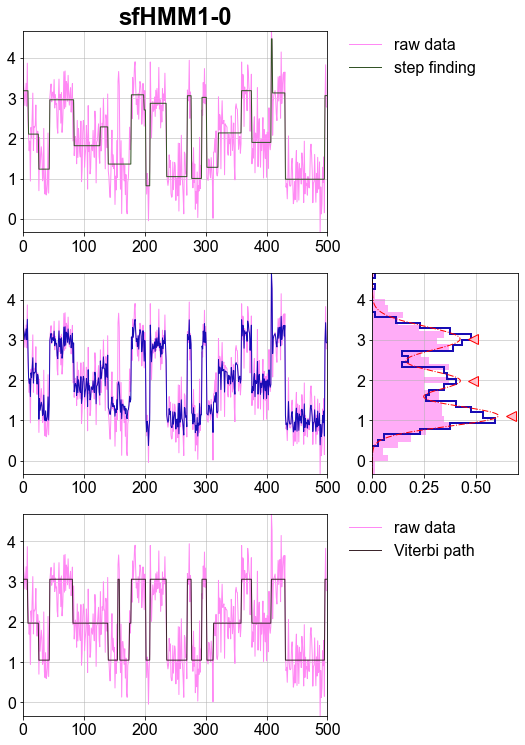

sfHMM1(model='GaussStep', name='sfHMM1-0', psf=0.042806973496989774,
       sg0=0.2113170614661793)

In [2]:
data = hmm_sampling(3, 500) # 3-state, 500-frame
sf = sfHMM1(data)
sf.run_all()

For multiple trajectories, use `sfHMMn`.

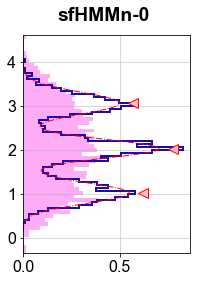

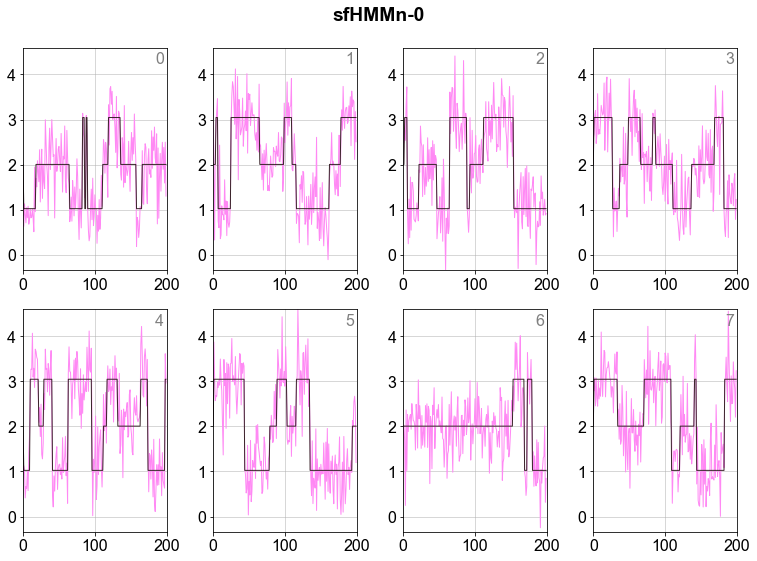

sfHMMn(model='GaussStep', name='sfHMMn-0', sg0=0.15139758195643316)

In [3]:
msf = sfHMMn()
for i in range(8):
    d = hmm_sampling(3, 200) # 3-state, 200-frame
    msf.append(d)            # append a data
msf.run_all()

## 2. Parameters and Methods

`sfHMM1` class and `sfHMMn` class have a similar structure (both inherit `sfHMMBase`) so that they have many attributes and methods in common. Also, `sfHMMBase` inherits `GaussianHMM` in [hmmlearn](https://github.com/hmmlearn/hmmlearn) so that all the methods in `GaussianHMM` are supported.

#### Parameters

All the parameters are optional.
- `sg0` ... The parameter used in denoising process.
- `psf` ... The parameter used in step finding.
- `krange` ... Range of the number of hidden states.
- `model` ... Step finding model.
- `name` ... Name of the object.

#### Methods

sfHMM is composed of four steps.

1. `step_finding()` ... Step finding by likelihood maximization.
2. `denoising()` ... The standard deviation of noise is cut off to `sg0`.
3. `gmmfit()` ... Gaussian mixture model clustering.
4. `hmmfit()` ... HMM parameter initialization and optimization.

... and some utility functions.

- `plot()` ... visualize the results of sfHMM analysis.
- `run_all()` ... run all the four steps and plot the results.
- `tdp()` ... show the results in pseudo transition density plot.

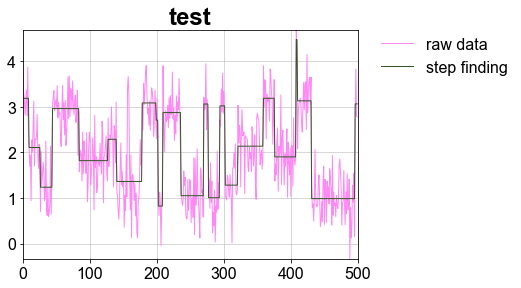

In [4]:
sf = sfHMM1(data, psf=0.03, name="test")
sf.step_finding()
sf.plot()

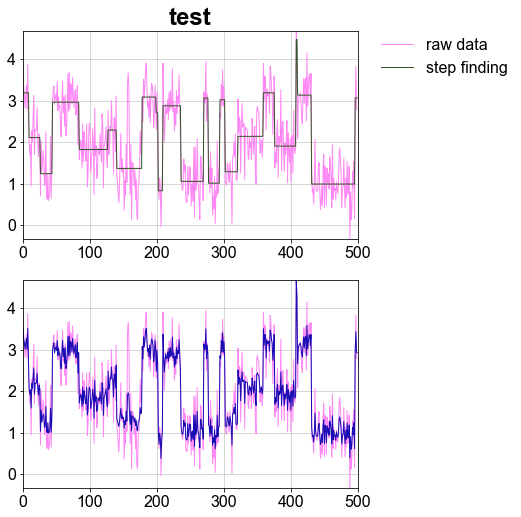

In [5]:
sf.denoising()
sf.plot()

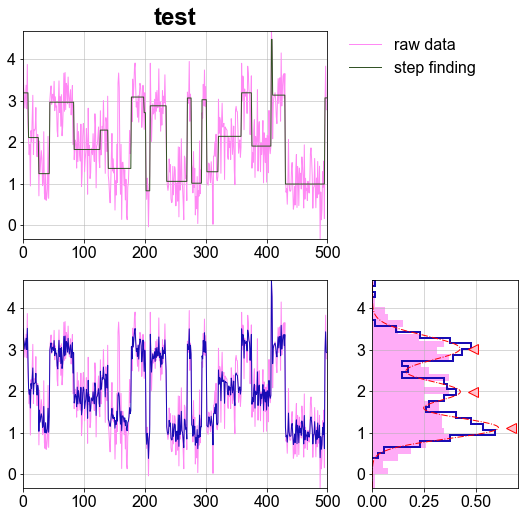

In [6]:
sf.gmmfit(n_init=3)
sf.plot()

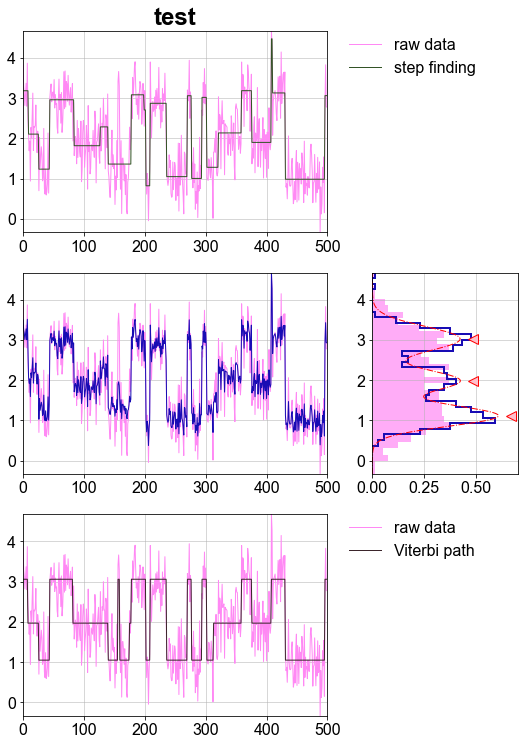

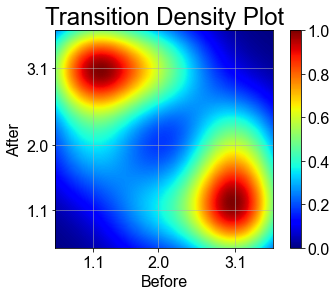

In [7]:
sf.hmmfit()
sf.plot()
sf.tdp()

## 3. Attributes Added during Analysis

Attributes are sequencially added to the object.

- After `step_finding`

  - `step` ... `GaussStep` if Gauss model or `PoissonStep` if Poisson model, but any `BaseStep` objects defined in `step` module are compatible. This object has following attributes:
    - `fit` ... Fitting result.
    - `n_step` ... The number of steps (region between two signal change points).
    - `step_list` ... List of signal change points.
    - `mu_list` ... list of mean values of each step.
    - `len_list` ... list of step lengths (`step_list[i+1] - step_list[i]`).
    - `step_size_list` ... list of signal change (`mu_list[i+1] - mu_list[i]`). 
  - `psf` ... Automatically determined here if needed.

- After `denoising`  

  - `data_fil` ... Data after denoised.
  - `sg0` ... Automatically determined here if needed.

- After `gmmfit`

  - `gmm_opt` ... The optimal Gaussian mixture model in the form of `GMM1` object. `GMM1` inherits `sklearn.mixture.GaussianMixture`. The only Difference is that all the parameters are sorted after fitting.

  - `gmm` ... `GMMs` object defined in `gmm` module, if AIC/BIC minimization is chosen. This object contains `GMM1` objects with different number of states.
  - `n_components` ... The number of states.
  - `states` ... State sequence, predicted only with the results in 1-3.

- After `hmmfit`
    
  - `means_`, `covars_`, `transmat_`, `startprob_` ... Parameters in Gaussian HMM. For detailed definition, see [hmmlearn](https://github.com/hmmlearn/hmmlearn).
  - `states` (updated after `gmmfit`) ... State sequence, optimized using Viterbi algorithm. This array takes values {0, 1, 2, ...}.
  - `viterbi` ... Signal sequence of Viterbi pass. This array takes values {`means_[0]`, `means_[1]`, `means_[2]`, ...}, so that basically you can plot `viterbi` and `data_raw` on the same figure.


## 4. Customizing Plots

The super class `sfHMMBase` has class attributes that is passed to `matplotlib` every time you plot. You can change them by updating the dictionaries.

- `colors` ... Line colors of each data.
- `styles` ... Styles of plot. See `rcParams` of `matplotlib`.


In [8]:
print(sfHMM1.colors)
print(sfHMM1.styles)

{'raw data': '#FF89F4', 'step finding': '#335426', 'denoised': '#180CB4', 'Viterbi path': '#3B252B'}
{'font.size': 16, 'lines.linewidth': 1, 'axes.titlesize': 24, 'font.family': 'serif', 'font.serif': 'Arial', 'axes.grid': True, 'axes.labelsize': 16, 'grid.linewidth': 0.5, 'legend.frameon': False, 'boxplot.meanprops.linewidth': 1}


## 5. Additional Attributes and Methods in sfHMMn

Basically `sfHMMn` can be used similarly as `sfHMM1`, while it has other methods for convenience.

- `append` ... Append one dataset.
- `appendn` ... Append list of datasets.
- `from_pandas` ... Append datasets from `pandas.DataFrame`.
- `self[i]` ... The `sfHMM1` object of $i$-th trace. The real list of objects is `_sf_list`. Iteration is defined on this list.
- `run_all_separately` ... Run `run_all` for each `sfHMM1` separately.


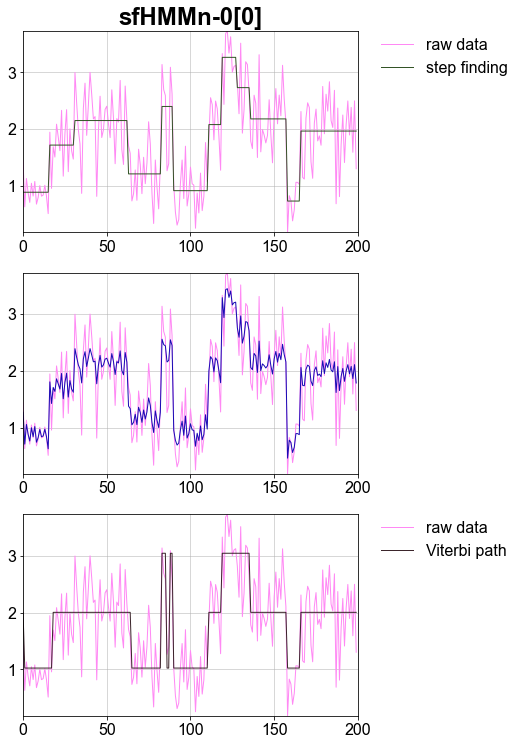

sfHMMn-0[0]
sfHMMn-0[1]
sfHMMn-0[2]
sfHMMn-0[3]
sfHMMn-0[4]
sfHMMn-0[5]
sfHMMn-0[6]
sfHMMn-0[7]


In [9]:
# plot the first trace and its analysis results.
msf[0].plot()

# print each name
for sf in msf:
    print(sf.name)

## 6. Application to Motor Stepping

sfHMM can be modified for application to motor stepping trajectories. `sfHMM1Motor` (for single trajectory) and `sfHMMnMotor` (for multiple trajectories) in `sfHMM.motor` module have similar API as `sfHMM1` and `sfHMMn` but there are slight differences due to specialization to motor stepping trajectories such as sparse transition and large number of states.

#### Differences in Parameters

- `krange` ... Because it is hard to define the number of states, this parameter is not needed to be predefined. This parameter can be estimated in `gmmfit()` based on the step finding results.
- `max_stride` ... The maximum size of state transition. Transition further than this will be ignored because transition probability for it will be near zero. For most motors this parameter should be set to 1 or 2.

#### Differences in Attributes and Methods

- `covariance_type` ... This is an attribute defined in `hmmlearn`. Because all the state should have the same distribution, this is set to `'tied'` here.
- `transmat_kernel` ... Independent paramter set in the transition probability matrix. The length of this array is equal to `max_stride*2+1`. This is passed to `transmat_` getter method every time to construct transition probability matrix.
- `gmmfit()` ... `method="Dirichlet"` is default because it is precise enough and it is much faster for big data. Also, if you want to use the predifined `krange`, you need to explicitly add keyward argument `estimation="none"`.
- `tdp()` ... In the case of motor stepping, transition desity plot is not a straightforward way to visualize transition. Histogram of transition frequency is plotted here.

#### Difference in HMM Algorithms

Although you don't need to care much about them, forward/backward algorithm and Viterbi algorithm is modified from the original ones because there are some restrictions in transition probability matrix. In `hmmlearn` those algorithms are coded in cython file "_hmmc.pyx", while in `sfHMM.motor` modified algorithms in "_hmmc_motor.pyx" are used instead.


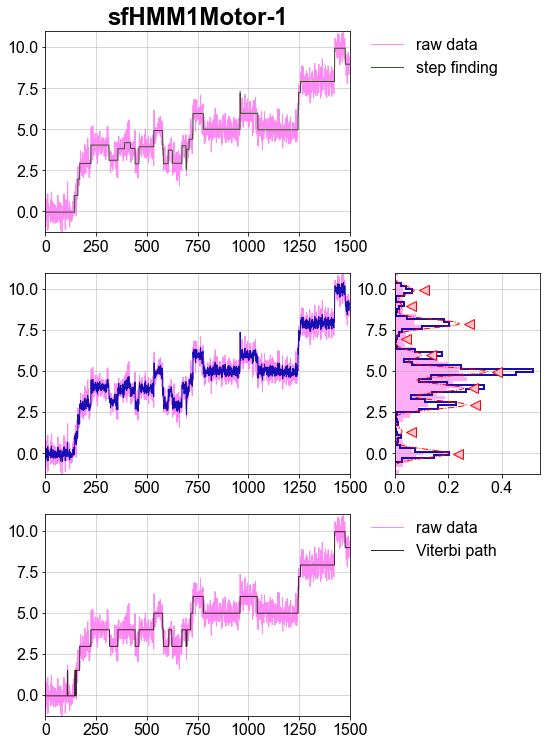

sfHMM1Motor(krange=(8, 14), model='GaussStep', name='sfHMM1Motor-1',
            psf=0.02517000230958917, sg0=0.19852365777155723)

In [10]:
from sfHMM import motor_sampling
from sfHMM.motor import sfHMM1Motor
data = motor_sampling(n_data=1500)
sf = sfHMM1Motor(data, max_stride=2)
sf.run_all()

[5.61278684e-11 7.94391609e-03 9.79473557e-01 1.18765451e-02
 7.05981340e-04]


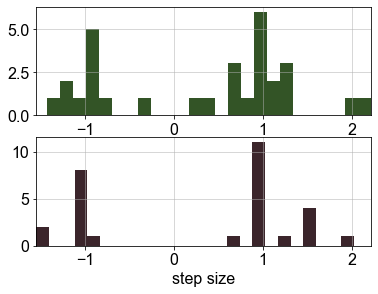

In [11]:
print(sf.transmat_kernel)
sf.tdp()

## 7. How to Use Step Finding Classes
In `sfHMM.step` module, 

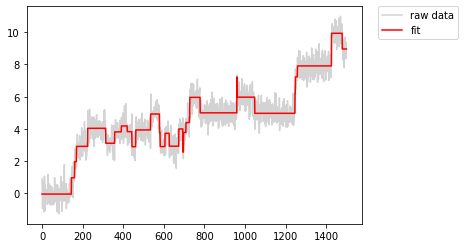

In [12]:
from sfHMM.step import GaussStep
g = GaussStep(data)
g.multi_step_finding()
g.plot()

## 8. How to Use GMM Clustering Classes

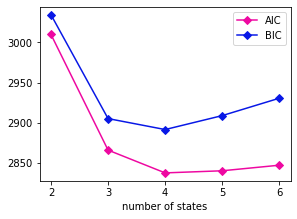

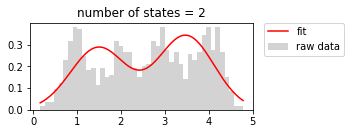

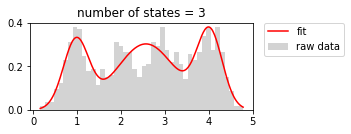

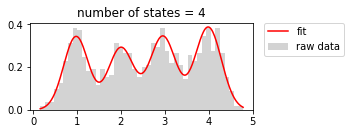

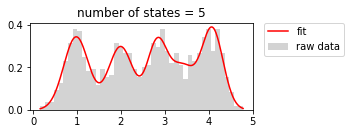

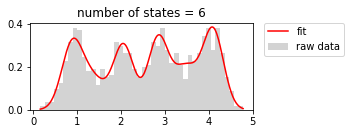

In [13]:
from sfHMM.gmm import GMMs
data = hmm_sampling(4,1000, 0.5, 0.3)
gmms = GMMs(data, krange=(2,6))
gmms.fit()
gmms.show_aic_bic()
gmms.plot_all()